# Homework 6: Correlations.

*Instructions:*
Please answer the following questions and submit your work
by editing this jupyter notebook and submitting it on Canvas.
Questions may involve math, programming, or neither,
but you should make sure to *explain your work*:
i.e., you should usually have a cell with at least a few sentences
explaining what you are doing.

Also, please be sure to always specify units of any quantities that have units,
and label axes of plots (again, with units when appropriate).

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
rng = np.random.default_rng()
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline


# 1. Ever Upwards

You are part of a team aiming to predict future costs for a coffee shop,
and are given the following model.
Let $X_0 = \$1.50$ be the price (to the shop) of a cup of coffee today,
and model the price $n$ weeks from now as $X_n = X_{n-1} + Z_n$,
where each $Z_n$ has a Normal distribution with mean \\$0.10 and standard deviation \\$0.10,
and is independent of other $Z$.
We want to see how well we can predict prices for the next 10 weeks under this model.

*(a)* If we define $Z = (Z_1, Z_2, \ldots, Z_{10})$,
    and $X = (X_1, X_2, \ldots, X_{10})$,
    then (taking $X$ and $Z$ to be column vectors)
    we can write $X = X_0 + AZ$ for some matrix $A$.
    What is that matrix?

*(b)* What is the mean and covariance matrix of $X$?
    Explain, and check by simulation.

###a
Breakdown of the matrix A:
* $X_1 = X_0 + Z_1$
* $X_2 = X_0 + Z_1 + Z_2$
* $X_3 = X_0 + Z_1 + Z_2 + Z_3$
* . . .
* $X_n = X_0 + \Sigma_n^{i =1}Z_i$
i, and 0s after that.

So, A is a lower triangular matrix of size 10x10 where each row i has 1s from col 1 to i, and 0s after that.

###b
Mean of X:

$\mathbb{E}[X] = X_0 + A \cdot \mathbb{E}[Z]$

Since $\mathbb{E}[Z_i] = 0.10 \text{ , then } \mathbb{E}[Z] = 0.10 \text{(a 10D vector of 0.10s )}$

$\mathbb{E}[X] = 1.5 + A \cdot 0.10$

Covariance of X:

Since $Cov(Z) = 0.01 \cdot I $, then:

$\text{Cov(X)} = A \cdot \text{Cov(Z)} * A^T =0.1 * AA^T$

In [7]:
# Question 1a)
# Create the A matrix
n = 10
A = np.tril(np.ones((n, n)))
print(A)


# Question 1b)
# Parameters
X0 = 1.5
mu_Z = 0.10
sigma_Z = 0.10
n_samples = 10000
# Simulate Z and compute X = X0 + A @ Z
Z_samples = rng.normal(loc=mu_Z, scale=sigma_Z, size=(10, n_samples))
X_samples = X0 + A @ Z_samples

# Sample mean and covariance
mean_X_sim = np.mean(X_samples, axis=1)
cov_X_sim = np.cov(X_samples)

# Theoretical mean and covariance
mean_X_theory = X0 + A @ np.full(10, mu_Z)
cov_X_theory = (sigma_Z**2) * A @ A.T

# Show results
print("Simulated Mean:\n", mean_X_sim)
print("\nTheoretical Mean:\n", mean_X_theory)

print("\nSimulated Covariance Matrix:\n", np.round(cov_X_sim, 4))
print("\nTheoretical Covariance Matrix:\n", np.round(cov_X_theory, 4))


[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Simulated Mean:
 [1.60178637 1.70263454 1.80321738 1.9042249  2.00288808 2.10164325
 2.20221082 2.30096517 2.40182218 2.50336525]

Theoretical Mean:
 [1.6 1.7 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5]

Simulated Covariance Matrix:
 [[0.0099 0.0099 0.01   0.0099 0.01   0.0099 0.01   0.0099 0.0099 0.0099]
 [0.0099 0.0198 0.0199 0.02   0.02   0.0199 0.0201 0.0202 0.0202 0.0202]
 [0.01   0.0199 0.03   0.0301 0.0302 0.0303 0.0303 0.0305 0.0304 0.0305]
 [0.0099 0.02   0.0301 0.0405 0.0404 0.0403 0.0404 0.0406 0.0406 0.0408]
 [0.01   0.02   0.0302 0.0404 0.0502 0.05   0.0501 0.0504 0.0503 0.0504]
 [0.0099 0.0199 0.0303 0.0403 0.05   0.0599 0.0601 0.0602 0.0602 0.0602]
 [0.01  

# 2. Books by a different name

In class, we did PCA on word count data from passages from three books. The passages are in the file [data/passages.txt](https://uodsci.github.io/dsci345/class_material/fall_2022/homeworks/data/passages.txt) and the sources of each passage are in [data/passage_sources.tsv](https://uodsci.github.io/dsci345/class_material/fall_2022/homeworks/data/passage_sources.tsv). Repeat the analysis. You may use the same code from class to read in and process the data,
but you should *use [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)* to do the PCA.  Your results should be similar but not the same as those from class, since scikit-learn's implementation differs somewhat. Also, you don't need to show everything that we did in class
(use your judgement) but we encourage you to explore.

*Note:* part of this question is to figure out how what another method gives you maps on to what we discussed in class. Big clues are provided by the sizes of various outputs.

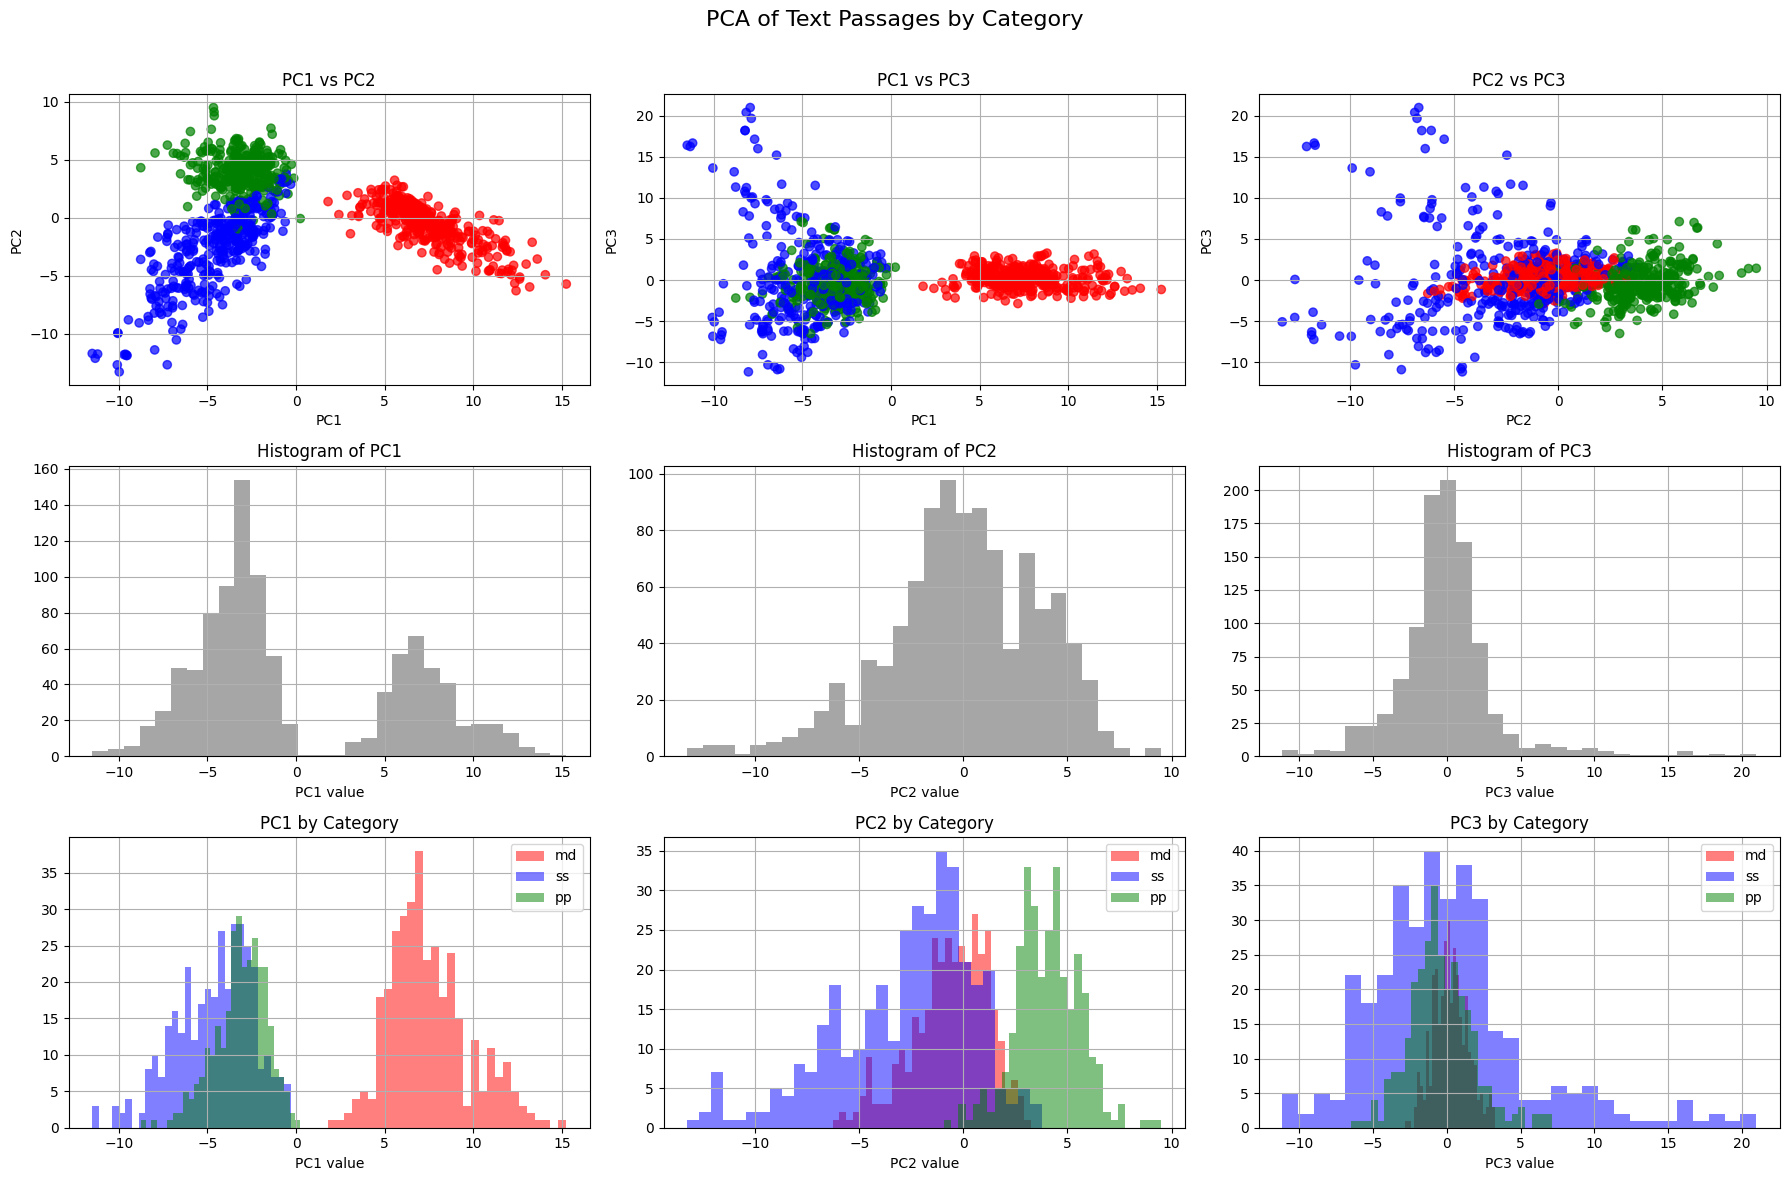

Explained Variance:
PC1: 3.40%
PC2: 1.37%
PC3: 1.23%
Total (PC1+PC2+PC3): 6.00%


In [14]:
# Load data
with open("passages.txt", "r", encoding="utf-8") as f:
    passages = f.read().strip().split("\n")

labels_df = pd.read_csv("passage_sources.tsv", sep="\t", header=0)
assert len(passages) == len(labels_df), "Mismatch in data lengths"

labels_df["passage"] = passages
categories = labels_df["source"]

# Vectorize
vectorizer = CountVectorizer(stop_words="english", max_features=1000)
X_counts = vectorizer.fit_transform(labels_df["passage"])

# PCA
scaler = StandardScaler(with_mean=False)
pca = PCA(n_components=3)
X_pca = make_pipeline(scaler, pca).fit_transform(X_counts.toarray())
explained = pca.explained_variance_ratio_

# Color mapping
color_map = {"md": "red", "ss": "blue", "pp": "green"}
colors = categories.map(color_map)

# Set up 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle("PCA of Text Passages by Category", fontsize=16)

# Row 1: Pairwise Scatter Plots
axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=colors, alpha=0.7)
axes[0, 0].set_title("PC1 vs PC2")
axes[0, 0].set_xlabel("PC1")
axes[0, 0].set_ylabel("PC2")
axes[0, 0].grid(True)

axes[0, 1].scatter(X_pca[:, 0], X_pca[:, 2], c=colors, alpha=0.7)
axes[0, 1].set_title("PC1 vs PC3")
axes[0, 1].set_xlabel("PC1")
axes[0, 1].set_ylabel("PC3")
axes[0, 1].grid(True)

axes[0, 2].scatter(X_pca[:, 1], X_pca[:, 2], c=colors, alpha=0.7)
axes[0, 2].set_title("PC2 vs PC3")
axes[0, 2].set_xlabel("PC2")
axes[0, 2].set_ylabel("PC3")
axes[0, 2].grid(True)

# Row 2: Histograms of PCs
for i in range(3):
    axes[1, i].hist(X_pca[:, i], bins=30, alpha=0.7, color="gray")
    axes[1, i].set_title(f"Histogram of PC{i+1}")
    axes[1, i].set_xlabel(f"PC{i+1} value")
    axes[1, i].grid(True)

# Row 3: Histograms of PCs split by category
for i in range(3):
    for cat, color in color_map.items():
        mask = (categories == cat).values
        axes[2, i].hist(X_pca[mask, i], bins=30, alpha=0.5, label=cat, color=color)
    axes[2, i].set_title(f"PC{i+1} by Category")
    axes[2, i].set_xlabel(f"PC{i+1} value")
    axes[2, i].grid(True)
    axes[2, i].legend()

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# Print explained variance
print("Explained Variance:")
print(f"PC1: {explained[0]*100:.2f}%")
print(f"PC2: {explained[1]*100:.2f}%")
print(f"PC3: {explained[2]*100:.2f}%")
print(f"Total (PC1+PC2+PC3): {explained[:3].sum()*100:.2f}%")


# 3. The Matrix

The secret vault can only be unlocked by a stream of numbers satisfying certain statistical properties.
You can pass in 5 floating-point numbers at a time,
and each set of 5 must be related to eachother in the following way:
they should be Normally distributed with mean zero and the ($5 \times 5$) covariance matrix:
$$\begin{aligned}
    M_{ij} = (1+i+j) \times 2^{-|i-j|} \qquad \text{for } 1 \le j \le 5, \quad 1 \le i \le 5 .
\end{aligned}$$
Write a function to produce a random set of 5 numbers of this form,
and test the result by verifying that (a) $\text{var}[X_2] = 5$ and
(b) $\text{cov}[X_3,X_5] = 2.25$.

In [20]:
# Step 1: Build the true 5x5 covariance matrix using:
# M[i,j] = (1 + i + j) * 2^{-abs(i - j)}, for i,j from 1 to 5 (1-indexed)
def build_cov_matrix(n=5):
    M = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            M[i, j] = (1 + (i + 1) + (j + 1)) * 2 ** (-abs(i - j))
    return M

# Step 2: Generate samples from N(0, M)
def generate_samples(M, n_samples=100000):
    mean = np.zeros(M.shape[0])
    return np.random.multivariate_normal(mean, M, size=n_samples)

# Build matrix and simulate samples
M = build_cov_matrix()
samples = generate_samples(M)

# Step 3: Estimate the empirical covariance matrix
sample_cov = np.cov(samples, rowvar=False)

# Step 4: Check the target values
# var[X_2] (2nd entry, index 1)
# cov[X_3, X_5] (3rd and 5th entries, index 2 and 4)
print("Target Covariance Matrix M:\n", np.round(M, 3))
print(f"\nEmpirical Var[X2] ≈ {sample_cov[1,1]:.2f} (expected 5.00)")
print(f"Empirical Cov[X3, X5] ≈ {sample_cov[2,4]:.2f} (expected 2.25)")


Target Covariance Matrix M:
 [[ 3.     2.     1.25   0.75   0.438]
 [ 2.     5.     3.     1.75   1.   ]
 [ 1.25   3.     7.     4.     2.25 ]
 [ 0.75   1.75   4.     9.     5.   ]
 [ 0.438  1.     2.25   5.    11.   ]]

Empirical Var[X2] ≈ 4.97 (expected 5.00)
Empirical Cov[X3, X5] ≈ 2.21 (expected 2.25)
